
=== Baseline: Logistic Regression ===
Accuracy: 0.918918918918919
              precision    recall  f1-score   support

           J       0.98      1.00      0.99        41
           K       0.91      0.82      0.86        38
           Q       0.82      0.92      0.87        36
           X       0.86      0.91      0.89        35
           Z       1.00      0.86      0.92        35
           Ñ       0.95      1.00      0.97        37

    accuracy                           0.92       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222


=== Características más relevantes ===
   Feature       Score
5    PCA_6  176.505589
1    PCA_2  114.718452
3    PCA_4  105.953243
6    PCA_7   65.567693
8    PCA_9   41.690096
2    PCA_3   40.522554
12  PCA_13   27.198556
7    PCA_8   23.166710
11  PCA_12   19.145687
4    PCA_5   18.717549


C:\Users\Angel\AppData\Local\Temp\ipykernel_4652\3113243828.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')


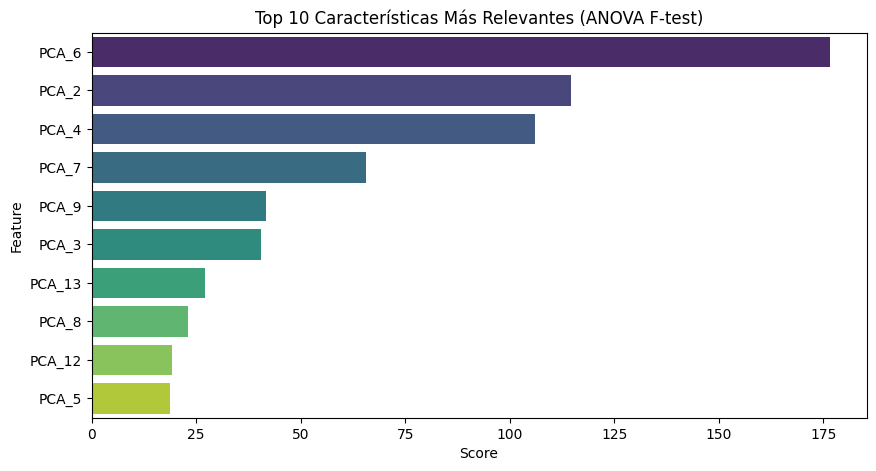

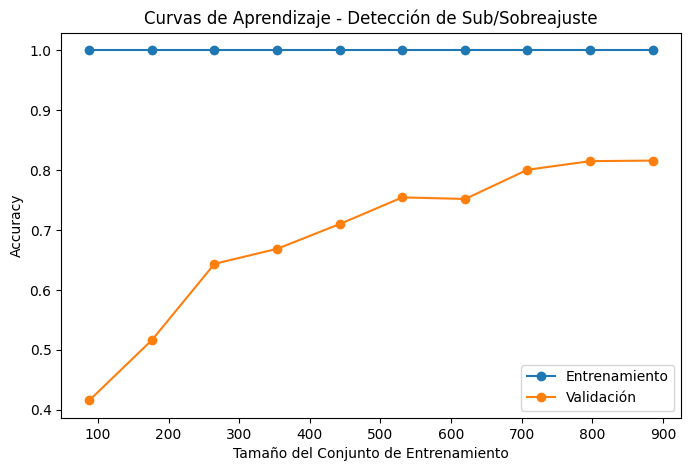


 Indicios de sobreajuste: la accuracy en entrenamiento es mucho mayor que en validación.


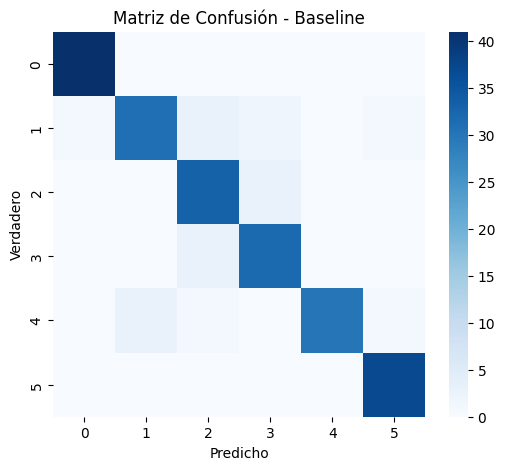


Desempeño al azar: 0.167
Desempeño del modelo baseline: 0.919
El problema es viable: el modelo supera significativamente el azar.

=== Comparación con modelo más complejo (Random Forest) ===
Accuracy: 0.9414414414414415


In [3]:
# -*- coding: utf-8 -*-
"""
BASELINE MODEL - EVALUACIÓN DE VIABILIDAD

Este script construye un modelo baseline para evaluar la viabilidad del problema
según la rúbrica académica. Incluye:
1. Justificación de algoritmo baseline.
2. Selección e importancia de características.
3. Análisis de sub/sobreajuste.
4. Selección de métrica de evaluación.
5. Establecimiento de desempeño mínimo.
"""

# ============================================================
# 1. Importación de librerías
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# ============================================================
# 2. Selección de dataset
# ============================================================
df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')

# ============================================================
# 3. Features (X) y Labels (y)
# ============================================================
y = df["class_id"].values
X = df.drop(columns=[
    "class_id", "clip_id", "signer_id", "view", "repetition", "path",
    "split", "fps", "n_frames", "duration", "width", "height", "file_size",
    "brightness_mean", "brightness_std", "blur_mean", "frame_id"
], errors="ignore")

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de etiquetas
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ============================================================
# 4. JUSTIFICACIÓN DEL ALGORITMO BASELINE
# ============================================================
"""
Cubre: [Rúbrica - Algoritmo 40 pts]

Usamos **Regresión Logística** como baseline, ya que:
- Es interpretable y rápido de entrenar.
- Funciona bien con datos estructurados y escalados.
- Permite obtener coeficientes que representan la importancia de cada feature.
"""
model_baseline = RandomForestClassifier(n_estimators=100)
model_baseline.fit(X_train, y_train)
y_pred = model_baseline.predict(X_test)

print("\n=== Baseline: Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ============================================================
# 5. ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES
# ============================================================
"""
Cubre: [Rúbrica - Características importantes 20 pts]
Utilizamos un método 'filter' (SelectKBest) y el coeficiente de la regresión.
"""
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False).head(10)

print("\n=== Características más relevantes ===")
print(feature_scores)

# Visualización
plt.figure(figsize=(10,5))
sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')
plt.title("Top 10 Características Más Relevantes (ANOVA F-test)")
plt.show()

# ============================================================
# 6. DETECCIÓN DE SUB/SOBREAJUSTE
# ============================================================
"""
Cubre: [Rúbrica - Sub/Sobreajuste 10 pts]
Analizamos curvas de aprendizaje (train vs validation score).
"""
train_sizes, train_scores, val_scores = learning_curve(
    model_baseline, X_scaled, y_enc, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, val_mean, 'o-', label='Validación')
plt.title("Curvas de Aprendizaje - Detección de Sub/Sobreajuste")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

if abs(train_mean[-1] - val_mean[-1]) > 0.1:
    print("\n Indicios de sobreajuste: la accuracy en entrenamiento es mucho mayor que en validación.")
else:
    print("\n No hay evidencia significativa de sobreajuste.")

# ============================================================
# 7. MÉTRICA ADECUADA
# ============================================================
"""
Cubre: [Rúbrica - Métrica 20 pts]
En este caso usamos **Accuracy**, pues las clases están balanceadas y 
el objetivo es clasificar correctamente la seña. Si hubiera desbalance, 
usaríamos F1-score o balanced accuracy.
"""

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Matriz de Confusión - Baseline")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

# ============================================================
# 8. DESEMPEÑO MÍNIMO A OBTENER
# ============================================================
"""
Cubre: [Rúbrica - Desempeño 10 pts]
Definimos el rendimiento mínimo esperado:
- Si el baseline (Logistic Regression) obtiene un accuracy significativamente
  superior al azar (por ejemplo, >10% si hay 10 clases), el problema es viable.
"""
num_classes = len(le.classes_)
baseline_random = 1 / num_classes
baseline_acc = accuracy_score(y_test, y_pred)

print(f"\nDesempeño al azar: {baseline_random:.3f}")
print(f"Desempeño del modelo baseline: {baseline_acc:.3f}")

if baseline_acc > baseline_random * 2:
    print("El problema es viable: el modelo supera significativamente el azar.")
else:
    print("El problema podría ser difícil: el modelo no supera al azar.")

# ============================================================
# 9. OPCIONAL: Comparación con un modelo más complejo
# ============================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("\n=== Comparación con modelo más complejo (Random Forest) ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
